In [2]:
import akshare as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

class DynamicZScoreStrategy:
    def __init__(self, symbol="510500", window=240, base_multiplier=1.5, vol_window=60, 
                 min_multiplier=1, max_multiplier=3.0, initial_capital=100000.0):
        """
        初始化动态Z-Score交易策略
        
        参数:
            symbol (str): ETF代码
            window (int): 计算Z-Score的窗口大小(周期数)，默认240周期即5天
            base_multiplier (float): 基础阈值倍数
            vol_window (int): 波动率估计窗口大小
            min_multiplier (float): 最小阈值倍数
            max_multiplier (float): 最大阈值倍数
        """
        self.symbol = symbol
        self.window = window
        self.base_multiplier = base_multiplier
        self.vol_window = vol_window
        self.min_multiplier = min_multiplier
        self.max_multiplier = max_multiplier
        self.data = None
        self.positions = []
        self.initial_capital=initial_capital
        
    def fetch_data(self, start_date, end_date):
        """
        从AKShare获取ETF分钟级数据
        """
        print(f"正在获取{self.symbol}从{start_date}到{end_date}的5分钟K线数据...")
        self.data = ak.fund_etf_hist_min_em(
            symbol=self.symbol,
            period="5",
            adjust="qfq",
            start_date=start_date,
            end_date=end_date
        )
        
        # 确保数据按时间排序
        self.data = self.data.sort_values('时间')
        self.data.reset_index(drop=True, inplace=True)
        
        # 计算收益率
        self.data['return'] = self.data['收盘'].pct_change()
        
        print(f"共获取到{len(self.data)}条数据")
        
    def calculate_zscore(self):
        """计算Z-Score指标"""
        if self.data is None:
            raise ValueError("请先获取数据")
            
        # 计算滚动均值和标准差
        self.data['rolling_mean'] = self.data['收盘'].rolling(window=self.window).mean()
        self.data['rolling_std'] = self.data['收盘'].rolling(window=self.window).std()
        
        # 计算Z-Score
        self.data['z_score'] = (self.data['收盘'] - self.data['rolling_mean']) / self.data['rolling_std']
        
        # 前window-1个数据点无法计算Z-Score
        self.data = self.data[self.window-1:].copy()
        
    def calculate_dynamic_thresholds(self):
        """计算动态阈值"""
        if 'z_score' not in self.data.columns:
            raise ValueError("请先计算Z-Score")
            
        # 计算历史Z-Score的标准差作为波动率指标
        self.data['z_volatility'] = self.data['z_score'].rolling(window=self.vol_window).std()
        
        # 对波动率进行平滑处理
        self.data['smoothed_vol'] = self.data['z_volatility'].ewm(span=20, adjust=False).mean()
        
        # 计算波动率因子 (0-1范围)
        min_vol = self.data['smoothed_vol'].min()
        max_vol = self.data['smoothed_vol'].max()
        self.data['vol_factor'] = (self.data['smoothed_vol'] - min_vol) / (max_vol - min_vol)
        
        # 计算动态阈值倍数
        self.data['dynamic_multiplier'] = self.base_multiplier * (1 + self.data['vol_factor'])
        
        # 应用最小和最大倍数限制
        self.data['dynamic_multiplier'] = np.clip(
            self.data['dynamic_multiplier'], 
            self.min_multiplier, 
            self.max_multiplier
        )
        
        # 计算动态阈值
        self.data['buy_threshold'] = -self.data['dynamic_multiplier']
        self.data['sell_threshold'] = self.data['dynamic_multiplier']
        
    def generate_signals(self):
        """生成交易信号"""
        if 'z_score' not in self.data.columns or 'buy_threshold' not in self.data.columns:
            raise ValueError("请先计算Z-Score和动态阈值")
            
        self.data['signal'] = 0  # 0表示无信号，1表示买入，-1表示卖出
        
        # 当Z-Score低于买入阈值时买入
        self.data.loc[self.data['z_score'] <= self.data['buy_threshold'], 'signal'] = 1
        
        # 当Z-Score高于卖出阈值时卖出
        self.data.loc[self.data['z_score'] >= self.data['sell_threshold'], 'signal'] = -1
        
        # 避免连续买入或卖出，只有当信号变化时才触发
        self.data['positions'] = self.data['signal'].diff()
        self.data.loc[self.data['signal'] == 0, 'positions'] = 0

    def sequence_print(self):
        price = self.data.iloc[-1]['收盘']
        z_score = self.data.iloc[-1]['z_score']
        threshold = self.data.iloc[-1]['buy_threshold']
        now = datetime.now().strftime("%Y-%m-%d %H:%M")
        print(f"--> [{now}] {self.symbol} Price: {price}\t ZScore: {z_score}\t Thres:±{threshold}")
        # 打印信号检测信息（仅检测最后一行）
        last_signal = self.data.iloc[-1]['signal']
        if last_signal != 0:
            buy_warn = "买入！"
            sell_warn = "卖出"
            print(f"!!!!!!!!!!! {self.symbol} 检测到交易信号: {buy_warn if last_signal == 1 else sell_warn} !!!!!!!")
        
    def backtest(self):
        """回测策略"""
        if 'positions' not in self.data.columns:
            raise ValueError("请先生成交易信号")
            
        # 初始化回测变量
        capital = self.initial_capital  # 初始资金
        position = 0  # 持仓数量
        trade_history = []
        portfolio_values = []
        
        # 添加一个资产净值列
        self.data['portfolio_value'] = np.nan
        
        for i, row in self.data.iterrows():
            # 执行买入信号
            pay = self.initial_capital / 10.0
            if row['positions'] == 1 and capital >= pay:
                buy_price = row['收盘']
                position += pay / buy_price
                capital -= pay
                trade_history.append({
                    'time': row['时间'],
                    'type': 'buy',
                    'price': buy_price,
                    'position': position,
                    'value': position * buy_price
                })
                
            # 执行卖出信号
            elif row['positions'] == -1 and position > 0:
                sell_price = row['收盘']
                ret = position * sell_price
                trade_history.append({
                    'time': row['时间'],
                    'type': 'sell',
                    'price': sell_price,
                    'position': position,
                    'value': capital
                })
                capital += ret
                position = 0
                
            # 记录当前资产价值
            if position > 0:
                current_value = position * row['收盘'] + capital
            else:
                current_value = capital
                
            self.data.at[i, 'portfolio_value'] = current_value
            portfolio_values.append(current_value)
            
        # 计算最终资产价值
        if position > 0:
            final_value = position * self.data.iloc[-1]['收盘'] + capital
        else:
            final_value = capital
            
        # 计算基准收益(买入持有策略)
        initial_price = self.data.iloc[0]['收盘']
        final_price = self.data.iloc[-1]['收盘']
        benchmark_return = (final_price - initial_price) / initial_price
        
        # 计算策略收益
        strategy_return = (final_value - self.initial_capital) / self.initial_capital
        
        # 计算交易次数
        buy_count = len([t for t in trade_history if t['type'] == 'buy'])
        sell_count = len([t for t in trade_history if t['type'] == 'sell'])
        
        print("\n回测结果:")
        print(f"初始资金: {self.initial_capital:,.2f}元")
        print(f"最终资产价值: {final_value:,.2f}元")
        print(f"策略收益率: {strategy_return*100:.2f}%")
        print(f"基准收益率(买入持有): {benchmark_return*100:.2f}%")
        print(f"买入次数: {buy_count}, 卖出次数: {sell_count}")
        print(f"总交易次数: {buy_count + sell_count}")
        
        # 计算最大回撤
        portfolio_series = pd.Series(portfolio_values)
        max_value = portfolio_series.expanding().max()
        drawdown = (portfolio_series - max_value) / max_value
        max_drawdown = drawdown.min()
        print(f"最大回撤: {max_drawdown*100:.2f}%")
        
        return trade_history, final_value, strategy_return, benchmark_return, max_drawdown
        
    def plot_results(self):
        """可视化结果"""
        if self.data is None:
            raise ValueError("请先获取并处理数据")
            
        plt.figure(figsize=(16, 14))
        
        # 确保时间列为datetime类型
        self.data['时间'] = pd.to_datetime(self.data['时间'])
        # 创建整数索引作为X轴值 (确保曲线连续)
        self.data['int_index'] = np.arange(len(self.data))
        
        # 计算数据时间范围
        time_range = self.data['时间'].max() - self.data['时间'].min()
        total_hours = time_range.total_seconds() / 3600
        
        # 根据时间范围确定刻度间隔
        if total_hours <= 24:  # 小于24小时
            interval = max(1, int(len(self.data)/24))  # 每1-2小时一个刻度
            date_format = "%H:%M"
            rotation = 30
        elif total_hours <= 72:  # 1-3天
            interval = max(1, int(len(self.data)/12))  # 每半天一个刻度
            date_format = "%m-%d %H:%M"
            rotation = 30
        elif total_hours <= 168:  # 3-7天
            interval = max(1, int(len(self.data)/7))  # 每天一个刻度
            date_format = "%m-%d"
            rotation = 0
        else:  # 超过7天
            interval = max(1, int(len(self.data)/10))  # 每10%数据一个刻度
            date_format = "%m-%d"
            rotation = 0
        
        # 创建主要刻度位置和标签
        major_ticks = np.arange(0, len(self.data), interval)
        major_labels = self.data.iloc[major_ticks]['时间'].dt.strftime(date_format).tolist()
        
        # 绘制价格和交易信号
        ax1 = plt.subplot(4, 1, 1)
        ax1.plot(self.data['int_index'], self.data['收盘'], label='Price', color='blue', linewidth=1.5)
        ax1.plot(self.data['int_index'], self.data['rolling_mean'], label=f'{self.window} Periods Avg', 
                color='orange', linestyle='--', alpha=0.8)
        
        # 标记买卖信号
        buy_signals = self.data[self.data['positions'] == 1]
        sell_signals = self.data[self.data['positions'] == -1]
        if not buy_signals.empty:
            ax1.scatter(buy_signals['int_index'], buy_signals['收盘'], marker='^', s=80, 
                    color='red', label='B')
        if not sell_signals.empty:
            ax1.scatter(sell_signals['int_index'], sell_signals['收盘'], marker='v', s=80, 
                    color='green', label='S')
        
        # 设置X轴格式
        ax1.set_xticks(major_ticks)
        ax1.set_xticklabels(major_labels, rotation=rotation, ha='center')
        
        ax1.set_title(f'ETF {self.symbol} Price and Signals')
        ax1.set_ylabel('Price')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # 绘制Z-Score和动态阈值
        ax2 = plt.subplot(4, 1, 2, sharex=ax1)
        ax2.plot(self.data['int_index'], self.data['z_score'], label='Z-Score', color='purple', linewidth=1.5)
        ax2.plot(self.data['int_index'], self.data['buy_threshold'], color='red', 
                linestyle='--', alpha=0.7, label='Bth')
        ax2.plot(self.data['int_index'], self.data['sell_threshold'], color='green', 
                linestyle='--', alpha=0.7, label='Sth')
        ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax2.set_title('Z-Score And DynThres')
        ax2.set_ylabel('Z-Score')
        ax2.legend(loc='upper left')
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # 绘制动态阈值倍数和波动率
        ax3 = plt.subplot(4, 1, 3, sharex=ax1)
        ax3.plot(self.data['int_index'], self.data['dynamic_multiplier'], 
                label='Multi', color='blue', linewidth=1.5)
        ax3.axhline(self.base_multiplier, color='red', linestyle='--', 
                   alpha=0.7, label='BaseMulti')
        ax3.set_title('DynThresMulti')
        ax3.set_ylabel('Multi')
        
        # 添加第二个Y轴显示波动率
        ax3b = ax3.twinx()
        ax3b.plot(self.data['int_index'], self.data['smoothed_vol'], 
                 label='Vol', color='green', alpha=0.7)
        ax3b.set_ylabel('Vol', color='green')
        ax3b.tick_params(axis='y', labelcolor='green')
        
        ax3.legend(loc='upper left')
        ax3.grid(True, linestyle='--', alpha=0.7)
        
        # 绘制资产净值曲线
        ax4 = plt.subplot(4, 1, 4, sharex=ax1)
        # 基准收益曲线
        ax4.plot(self.data['int_index'], self.data['收盘'] / self.data.iloc[0]['收盘'] * 100000, 
                label='BaseRatio', color='gray', linestyle='--', alpha=0.8)
        # 策略收益曲线
        ax4.plot(self.data['int_index'], self.data['portfolio_value'], 
                label='SttgRatio', color='blue', linewidth=1.5)
        
        # 标记买入卖出点
        if not buy_signals.empty:
            ax4.scatter(buy_signals['int_index'], buy_signals['portfolio_value'], 
                       marker='^', s=80, color='red', label='B')
        if not sell_signals.empty:
            ax4.scatter(sell_signals['int_index'], sell_signals['portfolio_value'], 
                       marker='v', s=80, color='green', label='S')
        
        ax4.set_title('Portfolio')
        ax4.set_ylabel('Portfolio')
        ax4.legend(loc='upper left')
        ax4.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

正在获取512800从2025-05-27 15:05:00到2025-06-26 09:25:00的5分钟K线数据...
共获取到960条数据

回测结果:
初始资金: 100,000.00元
最终资产价值: 100,000.00元
策略收益率: 0.00%
基准收益率(买入持有): 6.02%
买入次数: 0, 卖出次数: 0
总交易次数: 0
最大回撤: 0.00%


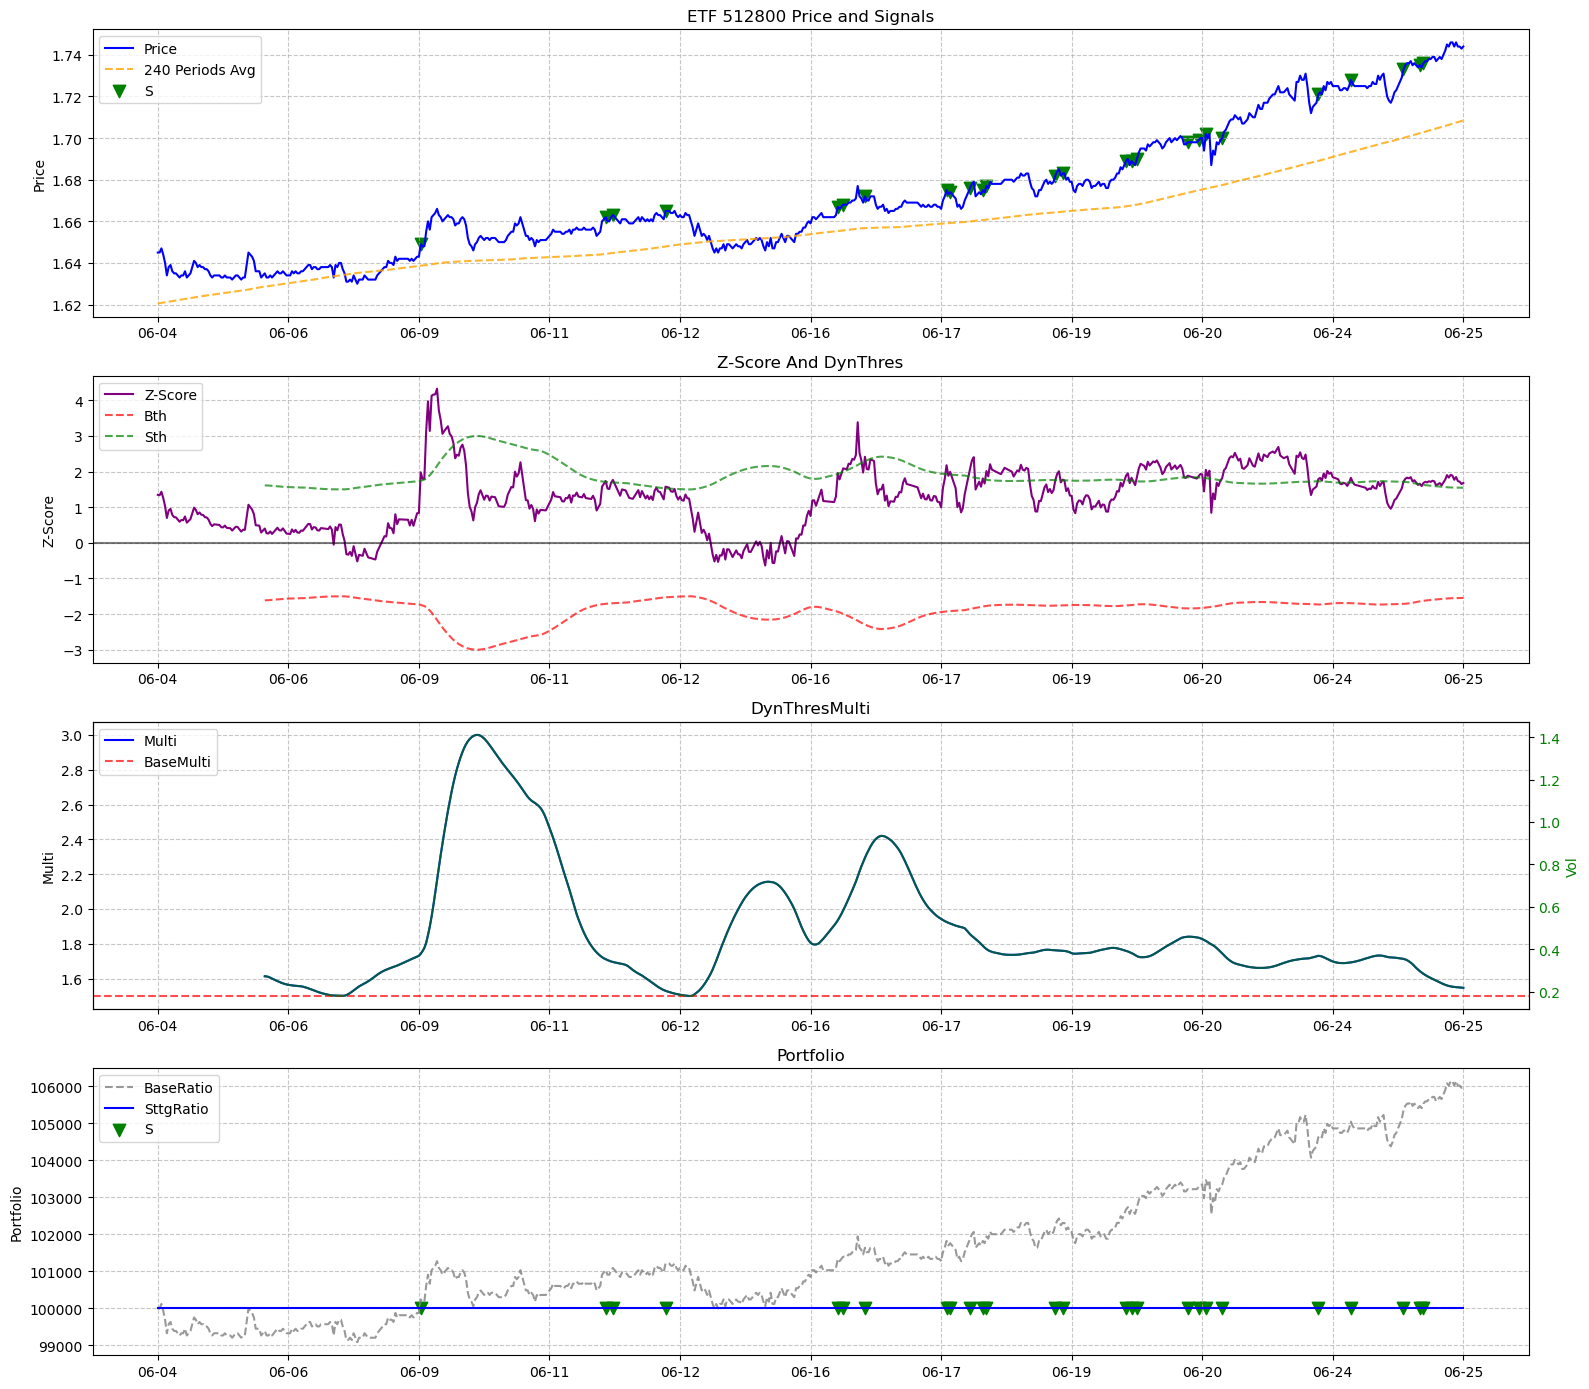

In [5]:
# 设置时间范围(获取最近约1个月的数据)
end_date = datetime.now().strftime("%Y-%m-%d 09:25:00")
start_date = (datetime.now() - timedelta(days=30)).strftime("%Y-%m-%d 15:05:00")

# 创建策略实例
strategy = DynamicZScoreStrategy(
    symbol="512800"
)

# 获取数据
strategy.fetch_data(start_date, end_date)

# 计算Z-Score
strategy.calculate_zscore()

# 计算动态阈值
strategy.calculate_dynamic_thresholds()

# 生成交易信号
strategy.generate_signals()

# 回测策略
trade_history, final_value, strategy_return, benchmark_return, max_drawdown = strategy.backtest()

# 可视化结果
strategy.plot_results()

In [1]:
from trading_signal_alert import TradingSignalAlert
import time
alert = TradingSignalAlert()
alert.send_alert('buy', '触发买入信号成功')

pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html
